In [1]:
get_ipython().magic('matplotlib inline')
get_ipython().magic('config InlineBackend.figure_format = "retina"')

import matplotlib.pyplot as pl

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import os
import sys
import numpy as np
import pandas as pd
from scipy import stats
from configobj import ConfigObj
from astropy import constants as c
from astropy import units as u
import pprint

import limbdark

pp = pprint.PrettyPrinter(indent=2)

def map_int(x):
    return list(map(int, x))

def map_float(x):
    return list(map(float, x))

sys.path.append('..')
from transitfit import TransitFit
from transitfit.util import mad_outliers, get_init_params, u_to_q

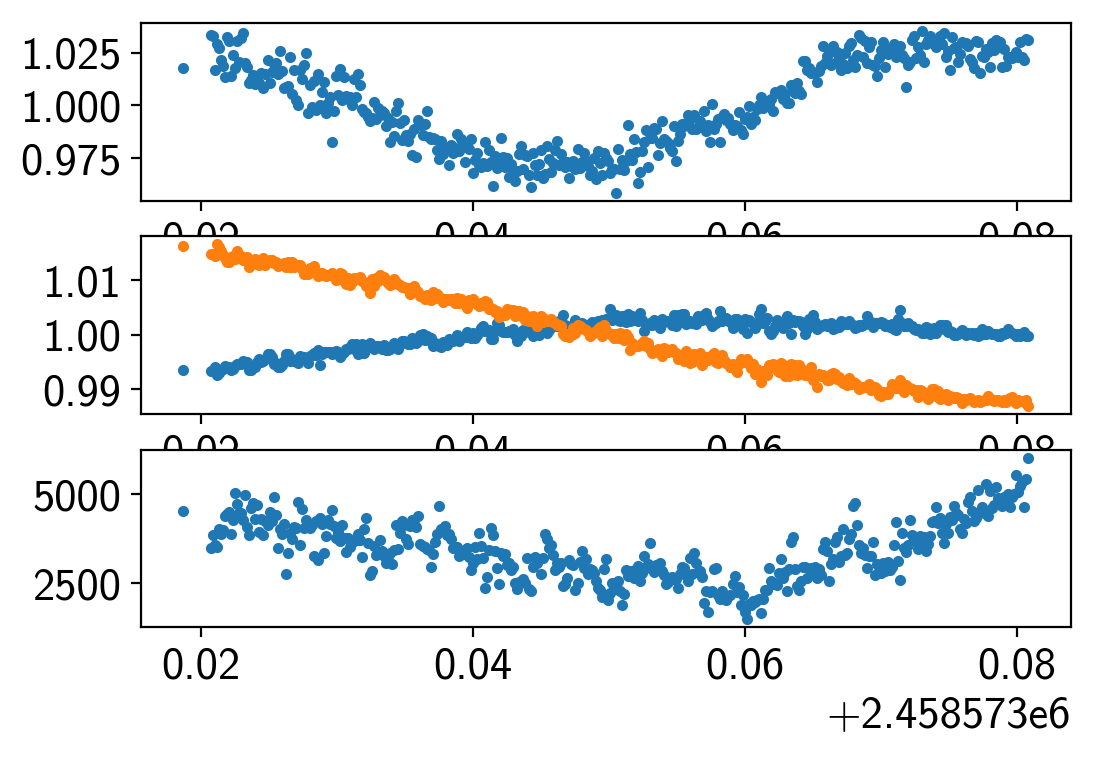

In [3]:
fp = '../data/20190330-TNT-TOI515_01-r.txt'
df = pd.read_table(fp, delim_whitespace=True, names='t f x y peak'.split())

time, flux, cenx, ceny, peak = df.values.T

time += 2400000.5
flux /= np.median(flux)

fig, axs = pl.subplots(3, 1)
axs[0].plot(time, flux, '.')
axs[1].plot(time, cenx/cenx.mean(), '.')
axs[1].plot(time, ceny/ceny.mean(), '.')
axs[2].plot(time, peak, '.')

0


<Container object of 3 artists>

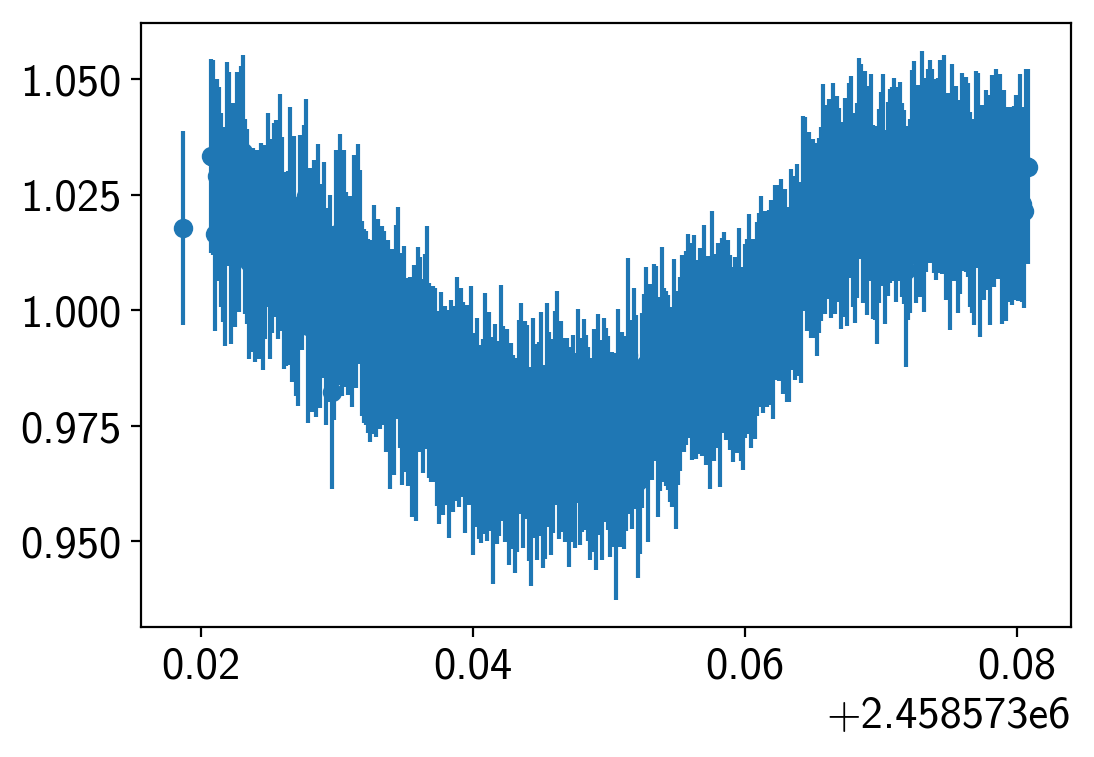

In [31]:
# aux = np.c_[np.ones_like(time), time-time.min(), (time-time.min())**2, cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]
# aux = np.c_[np.ones_like(time), time-time.min(), cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]
# aux = np.c_[np.ones_like(time), cenx/cenx.mean(), ceny/ceny.mean(), peak/peak.mean()]
aux = np.c_[np.ones_like(time), time-time.min(), cenx/cenx.mean(), ceny/ceny.mean()]

idx = mad_outliers(flux)
print(idx.sum())

time, flux, aux = time[~idx], flux[~idx], aux[~idx]
unc = flux.std()

pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [32]:
# bin the data
##############

# fp = 'TOI-136_irsf_181007_j.csv'
# df = pd.read_csv(fp)

# idx = mad_outliers(df['flux'].values)
# print('omitting {} outliers'.format(idx.sum()))
# df = df[~idx]

# binsize_min = 5
# binsize = binsize_min / (60 * 24)
# print(np.diff(df['BJD_TDB']).mean()*86400)
# bins = np.arange(df['BJD_TDB'].min(), df['BJD_TDB'].max(), binsize)
# groups = df.groupby(np.digitize(df['BJD_TDB'], bins))
# df_binned = groups.mean()
# df = df_binned.copy()

# aux = df['airmass sky dx dy fwhm peak'.split()].values
# time, flux, unc = df['BJD_TDB flux err'.split()].values.T
# pl.errorbar(time, flux, unc, marker='o', linestyle='none')

In [37]:
band = 'r*'

planets = { 'TOI515.01': 
           { 
               'per': 3.115247,
               't0': 2458493.283,
               't14': 0.096,
               'rprs': 0.16
           }
          }

star = {
    'teff': [4973, 172],
    'logg': [4.5, 0.5],
    'feh': [0.0, 0.5],
    'rad': [0.7, 0.1],
}

teff, logg, feh = [star.get(k) for k in 'teff logg feh'.split()]

ldp = limbdark.claret(band, teff[0], teff[1], logg[0], logg[1], feh[0], feh[1])
u1, u2 = ldp[0], ldp[2]
q1, q2 = u_to_q(u1, u2)

# logg = map_float(star['logg'])
# rad = map_float(star['rad'])
# n = 10000
# rad_s = rad[0] + np.random.randn(n) * rad[1]
# logg_s = logg[0] + np.random.randn(n) * logg[1]
# rho_s = rho(logg_s, rad_s)
# rhop = rho_s.mean(), rho_s.std()

# priors = dict(ld=ldp, rho=rhop)

pl_name = list(planets.keys())[0]
planet = planets[pl_name]
per, t0, t14, rprs = [planet.get(key) for key in 'per t0 t14 rprs'.split()]

while t0 < time.min():
    t0 += per
    
t0p = t0, 0.002097
perp = per, 0.000192
t14p = t14, 0.02
# priors = dict(ld=ldp, t0=t0p, per=perp, t14=t14p)
priors = dict(ld=ldp, per=perp, t14=t14p)
# priors = None

t0 = time.mean()
init_params = get_init_params(per, t0, t14, rprs, b=0.5, q1=q1, q2=q2)
init_params['priors'] = priors
init_params['ls'] = np.log(flux.std())
pp.pprint(init_params)

{ 'b': 0.5,
  'k': 0.16,
  'ls': -3.8627242742612804,
  'p': 3.115247,
  'priors': { 'ld': (0.5759, 0.06495702317605927, 0.1592, 0.04381305525277939),
              'per': (3.115247, 0.000192),
              't14': (0.096, 0.02)},
  'q1': 0.54037201,
  'q2': 0.3917154128689974,
  'r': 1.41,
  't0': 2458573.0507408995,
  't14': 0.096}


In [38]:
# fit = TransitFit(init_params, pl_name, time, flux, unc=unc, aux=aux)
fit = TransitFit(init_params, pl_name, time, flux, aux=aux)

In [39]:
fit.fit_map()

Initial L-M least squares fit successful
[[Variables]]
    t0:   2.4586e+06 +/- 0        (0.00%) (init= 2458573)
    p:    3.115247 (fixed)
    k:    0.16 (fixed)
    r:    1.41 (fixed)
    b:    1.11658567 +/- 0        (0.00%) (init= 0.5)
    q1:   0.540372 (fixed)
    q2:   0.3917154 (fixed)
    ls:  -3.862724 (fixed)
    c0:   0.01776312 +/- 0        (0.00%) (init= 0)
    c1:   0.39832337 +/- 0        (0.00%) (init= 0)
    c2:  -0.00306759 +/- 0        (0.00%) (init= 0)
    c3:  -0.01870763 +/- 0        (0.00%) (init= 0)
None
Transit depth: 25600 [ppm]
Transit duration: 0.84 [h]
Log-probability: 1009.1358672452116
True
[[Variables]]
    t0:   2458573 (fixed)
    p:    3.115247 (fixed)
    k:    0.16 (fixed)
    r:    1.41 (fixed)
    b:    0.88565282 (init= 1.116586)
    q1:   0.540372 (fixed)
    q2:   0.3917154 (fixed)
    ls:  -4.51528318 (init=-3.862724)
    c0:   10.6246472 (init= 0.01776313)
    c1:  -0.38261110 (init= 0.3983234)
    c2:  -7.33609447 (init=-0.003067597)
    c3

In [40]:
fit.plot_map()

In [41]:
# fit.fit_mcmc(two_stage=True)
fit.fit_mcmc(two_stage=True, steps=2000, nproc=4)

Running stage 1 MCMC (250 steps)...
Running production MCMC for 2000 steps...
[[Variables]]
    t0:   2.4586e+06 +/- 0.001435 (0.00%) (init= 2458573)
    p:    3.11525605 +/- 0.000225 (0.01%) (init= 3.115247)
    k:    0.40373252 +/- 0.065123 (16.13%) (init= 0.16)
    r:    12.0556904 +/- 3.449457 (28.61%) (init= 1.41)
    b:    1.06102372 +/- 0.083458 (7.87%) (init= 0.8856528)
    q1:   0.52043613 +/- 0.127506 (24.50%) (init= 0.540372)
    q2:   0.39718621 +/- 0.030531 (7.69%) (init= 0.3917154)
    ls:  -5.09591004 +/- 0.161369 (3.17%) (init=-4.515283)
    c0:   0.75384913 +/- 4.965701 (658.71%) (init= 10.62465)
    c1:  -0.18867948 +/- 0.891528 (472.51%) (init=-0.3826111)
    c2:  -0.25754581 +/- 2.704216 (1049.99%) (init=-7.336094)
    c3:  -0.52924080 +/- 2.149207 (406.09%) (init=-3.261712)
None
FIT_MCMC elapsed time: 120 sec


In [42]:
fit.plot_trace()

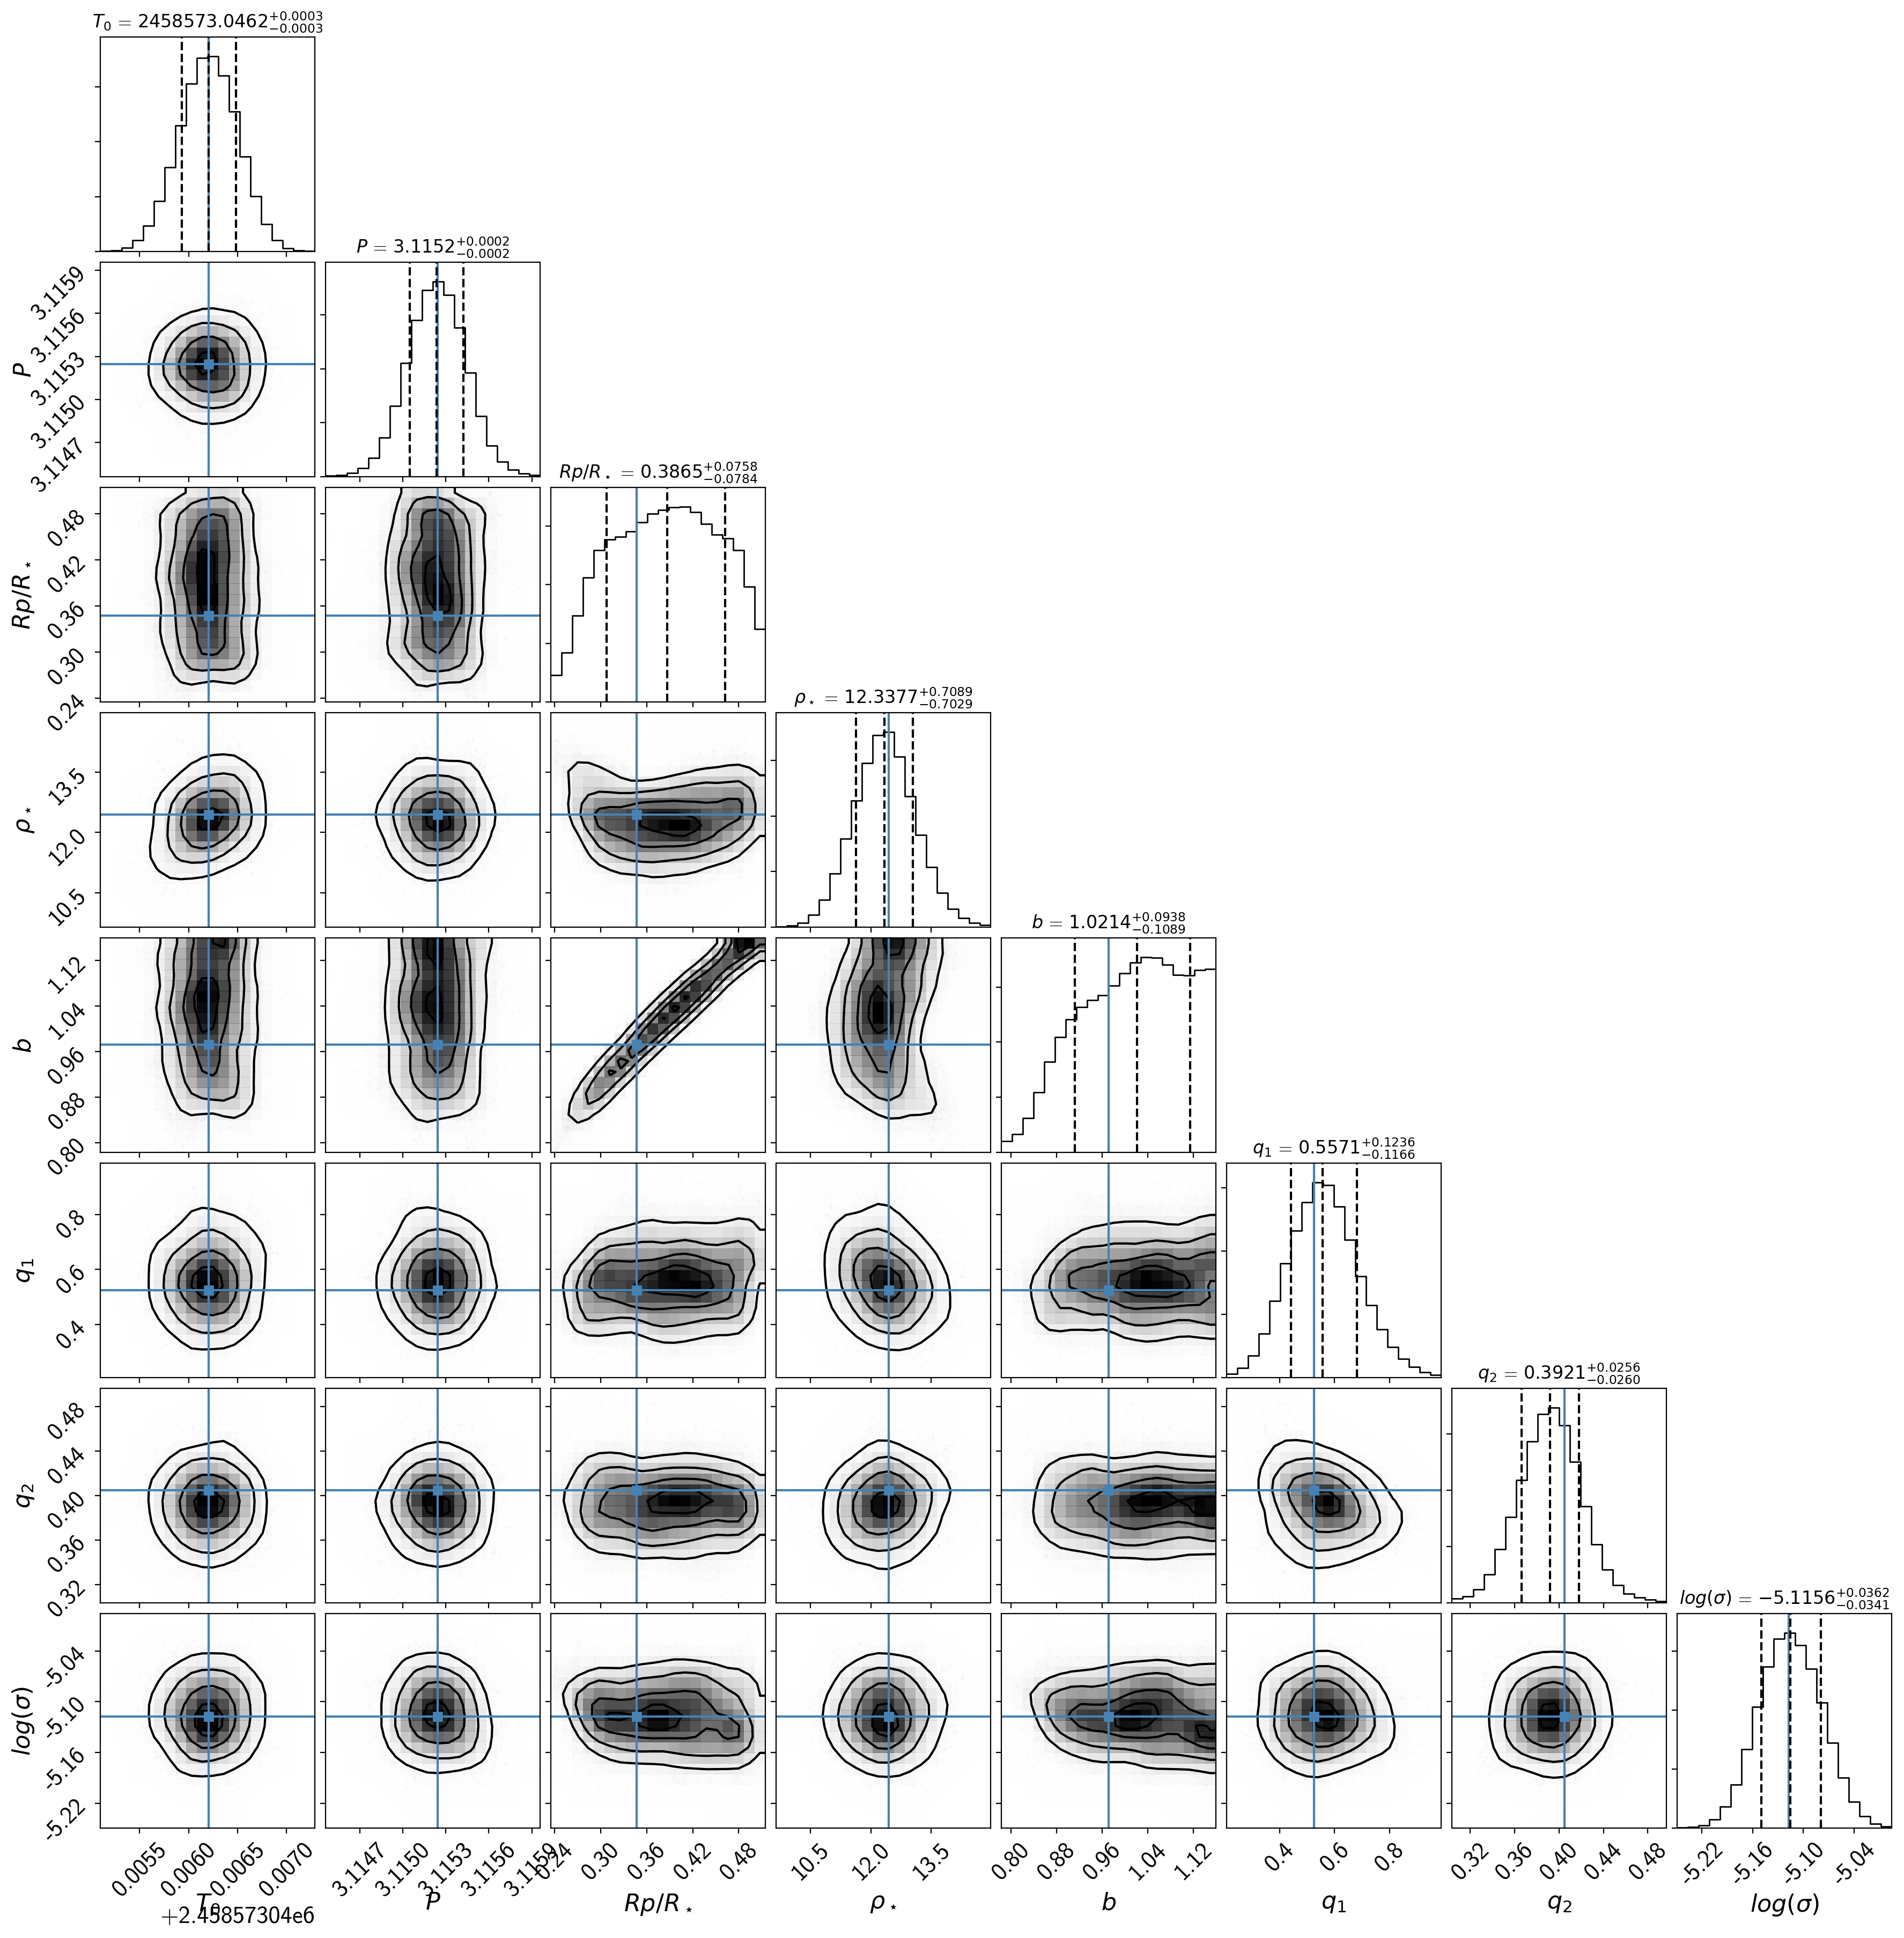

In [43]:
fit.burn_thin(burn=1500, thin=10)
fit.plot_corner()

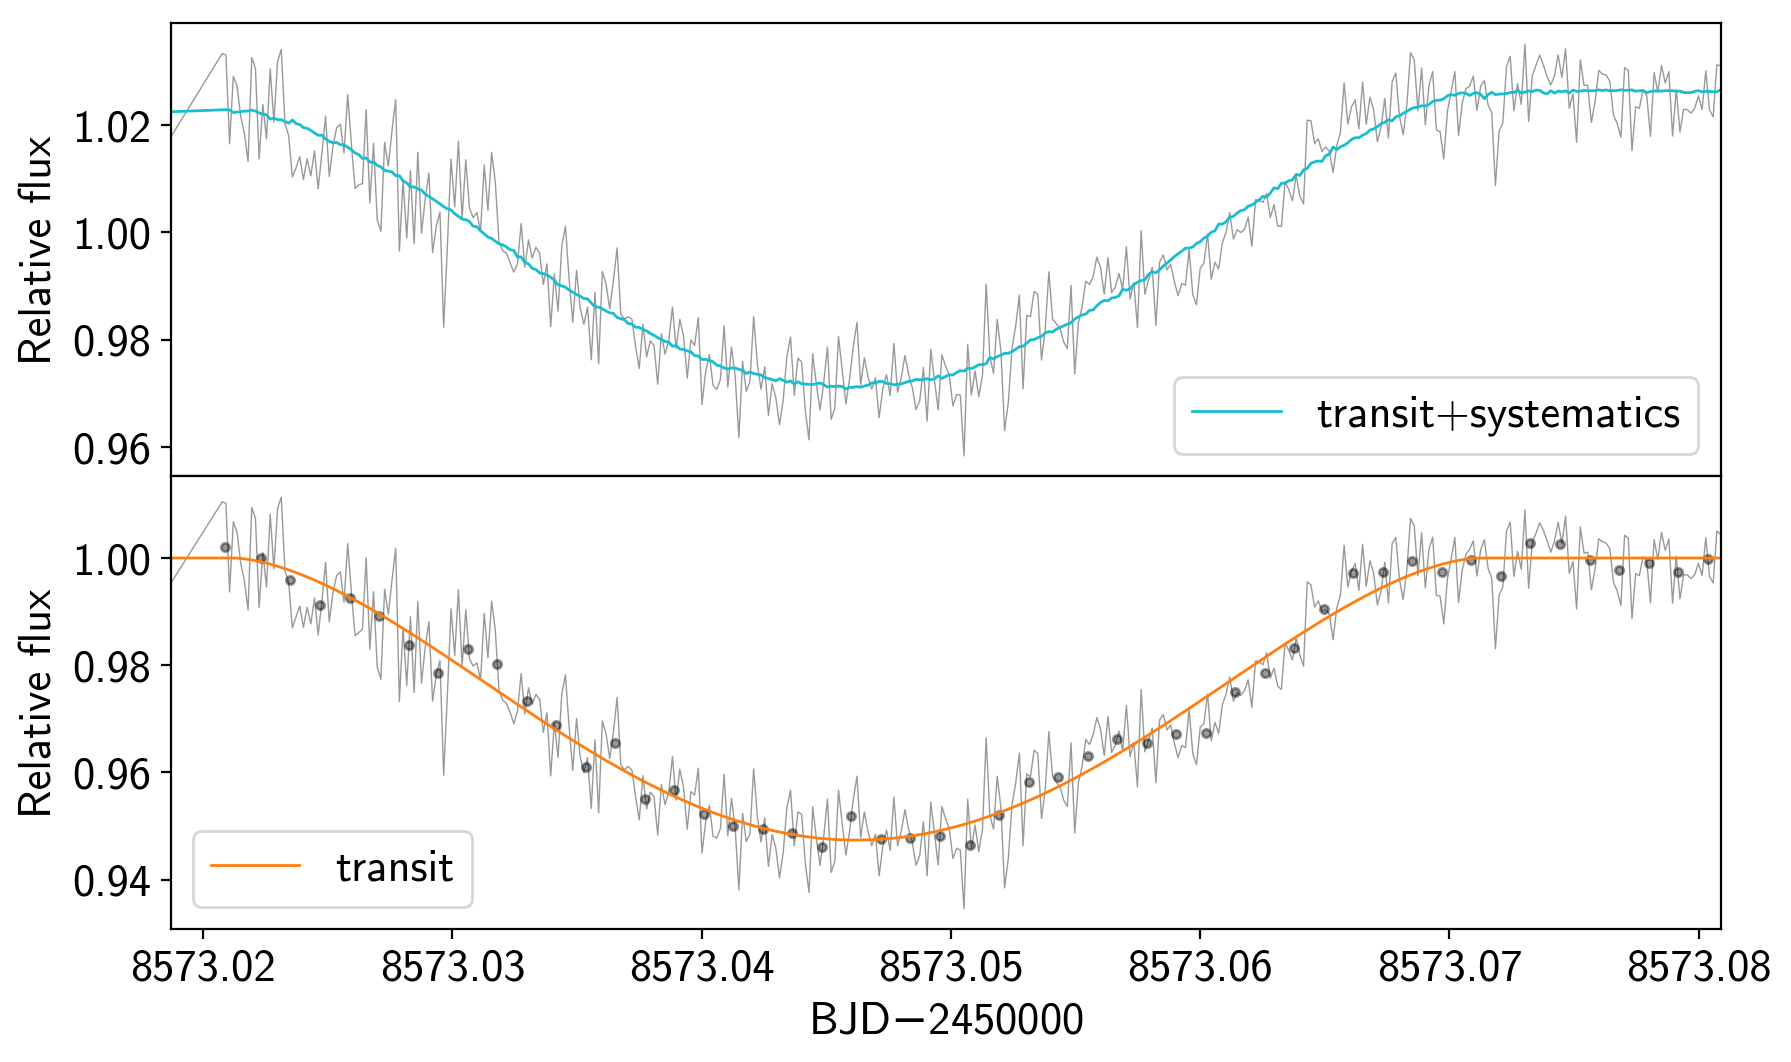

In [44]:
fit.plot_map()

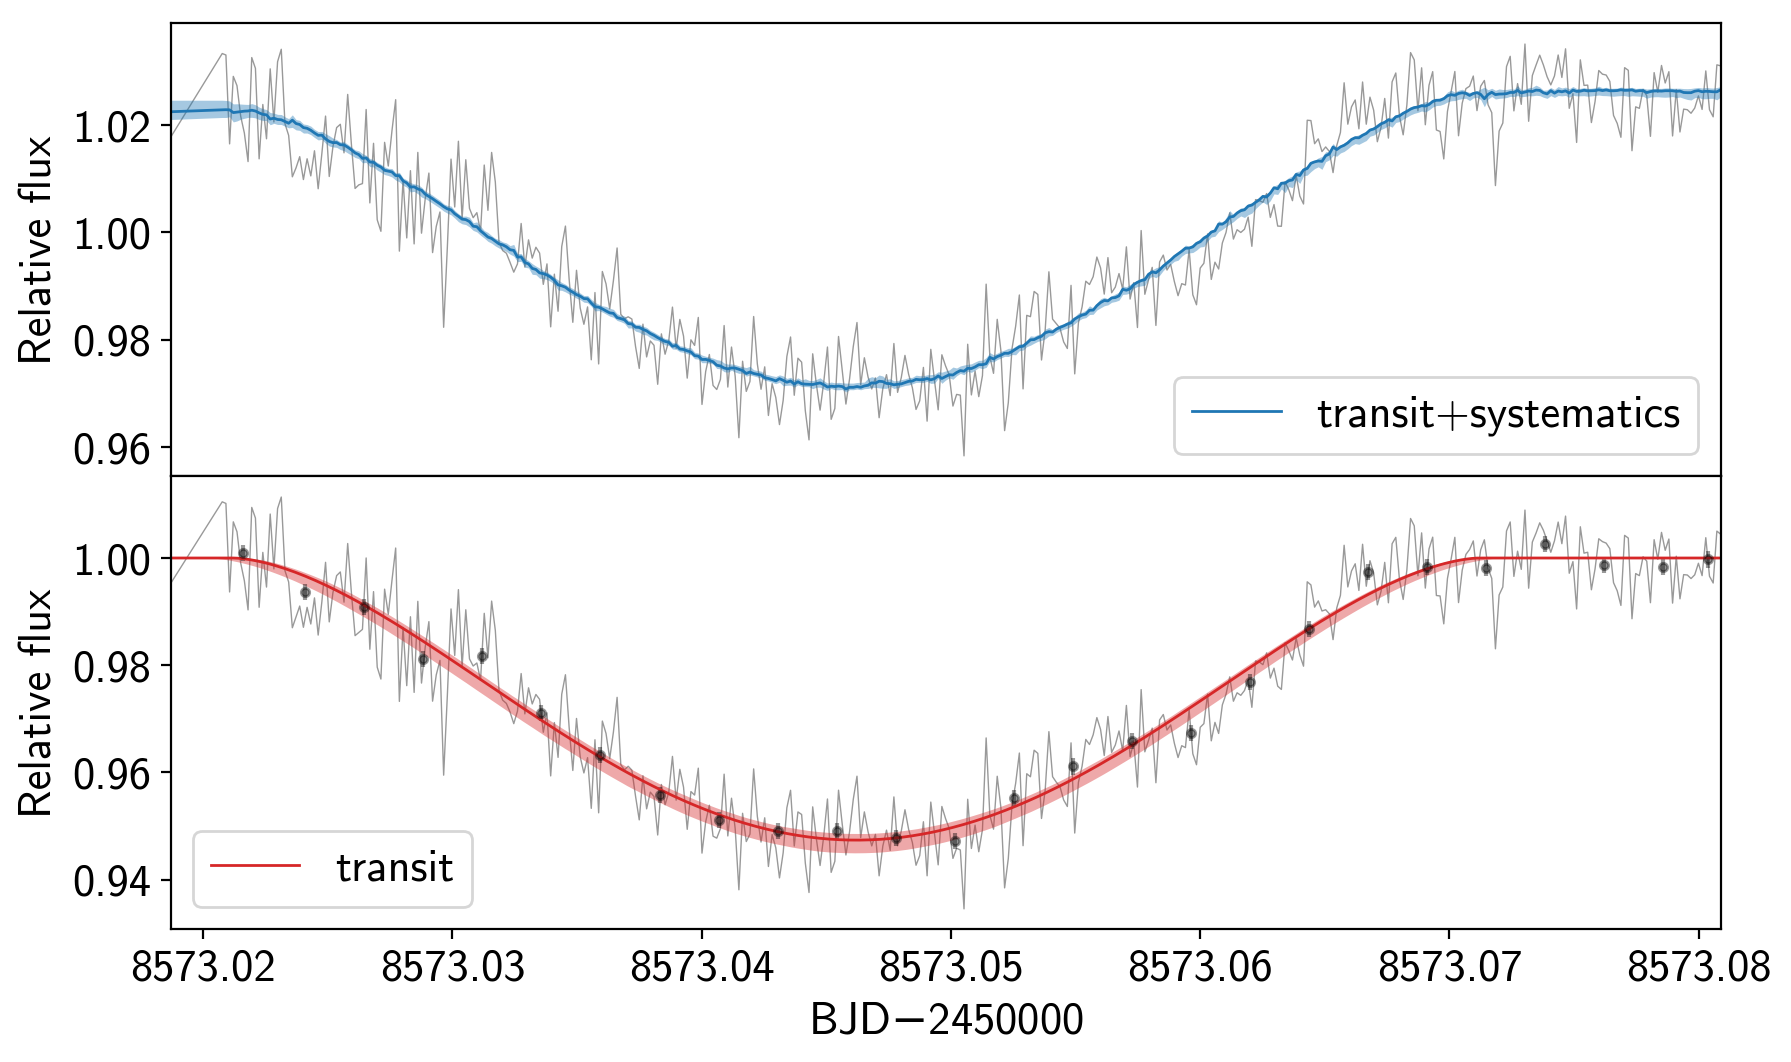

In [45]:
fig, axs = pl.subplots(2, 1, figsize=(10,6), sharex=True, sharey=False)
fit.plot_mcmc(binsize=16, c1='C0', c2='C3', sig=1, axs=axs)
# pl.setp(axs[1], ylim=(0.85,1.05))

In [46]:
fit.get_df(*star['rad']).describe()

../transitfit/util.py:79: RuntimeWarning: invalid value encountered in sqrt
  alpha = np.sqrt( (1 - k)**2 - b**2 )


t0            p            k            r            b  \
count  5.000000e+03  5000.000000  5000.000000  5000.000000  5000.000000   
mean   2.458573e+06     3.115236     0.384964    12.353338     1.014082   
std    2.751243e-04     0.000190     0.066758     0.716159     0.088596   
min    2.458573e+06     3.114460     0.235221     9.648539     0.783030   
25%    2.458573e+06     3.115107     0.329561    11.862201     0.943935   
50%    2.458573e+06     3.115236     0.386464    12.337736     1.021351   
75%    2.458573e+06     3.115365     0.439509    12.813432     1.086546   
max    2.458573e+06     3.115958     0.514623    14.974598     1.159965   

                q1           q2           ls           c0           c1  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean      0.562916     0.392213    -5.114943     0.397110    -0.089726   
std       0.120246     0.026756     0.034276     0.624662     0.197564   
min       0.207474     0.303462    -5.249138    -2.233288    -0.706319   
25%       0.478408     0.374343    -5.138875    -0.008274    -0.224122   
50%       0.557061     0.392101    -5.115554     0.408420    -0.092137   
75%       0.639593     0.409398    -5.090946     0.830987     0.043921   
max       0.986824     0.496695    -4.995648     2.458358     0.657308   

                c2           c3        rstar       pl_rad            a  \
count  5000.000000  5000.000000  5000.000000  5000.000000  5000.000000   
mean     -0.056060    -0.313394     0.701415    29.449078    18.498757   
std       0.345570     0.427027     0.099985     6.634012     0.357580   
min      -1.275027    -1.622468     0.330221    10.040969    17.042241   
25%      -0.281465    -0.602886     0.634879    24.421770    18.256967   
50%      -0.054556    -0.326806     0.701857    29.129205    18.497236   
75%       0.163598    -0.024741     0.769547    34.048841    18.733310   
max       1.100657     1.291858     1.089101    50.836171    19.730821   

               inc          t14  t23  shape  max_k  
count  5000.000000  5000.000000  0.0    0.0    0.0  
mean     86.856381     0.050581  NaN    NaN    NaN  
std       0.279129     0.001221  NaN    NaN    NaN  
min      86.280883     0.046660  NaN    NaN    NaN  
25%      86.630316     0.049732  NaN    NaN    NaN  
50%      86.819786     0.050539  NaN    NaN    NaN  
75%      87.058190     0.051379  NaN    NaN    NaN  
max      87.683980     0.055592  NaN    NaN    NaN

transit duration to short, shape wrong --> need t14 prior
--